In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np
import scipy as sp
from itertools import combinations, product
from scipy.stats import binom_test
%matplotlib inline

## Load Data

In [2]:
christian_tags = pd.read_csv("tags christian.csv", index_col=0)
christian_tags = christian_tags.replace('x', 1).fillna(0)
christian = christian_tags.as_matrix()

will_tags = pd.read_csv("tags will.csv", index_col=0)
will_tags = will_tags.replace('x', 1).fillna(0).iloc[:,:-3]
will = will_tags.as_matrix()

In [3]:
legend = {
    "Problem decomposition": "PD",
    "Compound analogy": "CA",
    "Problem reformulation": "PR",
    "Problem-based design": "PD",
    "Solution-based design": "SD",
    "Environmental impact analysis": "EI",
    "Mechanics": "ME",
    "Materials": "MA",
    "Sensing": "SE",
    "Physiology": "PH",
    "Intentional sustainability": "IS",
    "Serendipitous sustainability": "SS"
}

abbr_columns = [legend[x] for x in will_tags.columns]

christian_tags.columns = abbr_columns
will_tags.columns = abbr_columns
assert list(christian_tags.columns) == list(will_tags.columns) == list(abbr_columns)

# Dataset Characterization

In [4]:
names = ['Christian', 'Will']
for i, array in enumerate([christian, will]):
    print names[i]
    print 'mean:', array.sum(axis=0).mean()
    print 'std:', array.sum(axis=0).std()
    print 'min:', min(array.sum(axis=0))
    print 'max:', max(array.sum(axis=0))
    print 'N:', len(array)
    print ''

Christian
mean: 28.1666666667
std: 17.8224265713
min: 3.0
max: 65.0
N: 74

Will
mean: 28.0
std: 16.9115345253
min: 4.0
max: 62.0
N: 74



# Correlation

Data: Nominal, Dichotomous

How did we determine significance?

# Pearson Correlation and Fishers Exact

In [5]:
import itertools
def fishers_exact(matrix):
    p_values = [[0 for i in range(12)] for i in range(12)]
    odds_ratios = [[0 for i in range(12)] for i in range(12)]
    
    # Going through all combinations of columns
    for i, j in itertools.product(range(12), range(12)):
        # Logic tests comparing matrices to get frequency counts
        a = sum(np.logical_and(matrix.T[i], matrix.T[j]))
        b = sum(np.logical_and(np.logical_xor(matrix.T[i], matrix.T[j]), matrix.T[i]))
        c = sum(np.logical_and(np.logical_xor(matrix.T[i], matrix.T[j]), matrix.T[j]))
        d = sum(np.logical_and(np.logical_not(matrix.T[i]), np.logical_not(matrix.T[j])))
        assert b + c == sum(np.logical_xor(matrix.T[i], matrix.T[j]))
        assert a + b + c + d == len(matrix)

        odds_ratios[i][j], p_values[i][j] = sp.stats.fisher_exact([[a, b], [c, d]])
    
    return p_values, odds_ratios

In [6]:
names = ['Christian', 'Will']
df = []
for i, zeta in enumerate([(christian, christian_tags), (will, will_tags)]):
    dataframe = pd.DataFrame(columns=['Tag A', 'Tag B', 'Fisher P Value', 'Pearsons Correlation'])
    columns = set()
    count = 0
    p_values, odds_ratios = fishers_exact(zeta[0])
    for i, j in itertools.product(range(12), range(12)):
        if p_values[i][j] < 0.05 and i > j:
            count += 1
            columns.add(zeta[1].columns[i])
            columns.add(zeta[1].columns[j])
            dataframe.loc[count] = [zeta[1].columns[i], zeta[1].columns[j], p_values[i][j], zeta[1].corr().iloc[i, j]]
            #print '\n' + zeta[1].columns[i] + ' * ' + zeta[1].columns[j] + ':\np = ' + str(p_values[i][j]) + ', correlation = ' + str(zeta[1].corr().iloc[i, j])
            
    df.append(dataframe)
    
with open('Table 3.html', 'wb') as f:
    f.write('<h3><center>Coder 1</center></h3><br><center>')
    f.write(df[0].to_html(float_format=lambda x: '<center> %.3f </center>' % x)
            .replace('&lt;', '<').replace('&gt;', '>'))
    f.write('</center>')
    f.write('<h3><center>Coder 2</center></h3><br><center>')
    f.write(df[0].to_html(float_format=lambda x: '<center> %.3f </center>' % x)
            .replace('&lt;', '<').replace('&gt;', '>'))
    f.write('</center>')

In [7]:
with open('Table 2.html', 'wb') as f:
    f.write('<h3><center>Coder 1</center></h3><br><center>')
    f.write(christian_tags.corr().to_html(float_format=lambda x: '<center> %.3f </center>' % x)
            .replace('&lt;', '<').replace('&gt;', '>'))
    f.write('</center>')
    f.write('<h3><center>Coder 2</center></h3><br><center>')
    f.write(will_tags.corr().to_html(float_format=lambda x: '<center> %.3f </center>' % x)
            .replace('&lt;', '<').replace('&gt;', '>'))
    f.write('</center>')
    
with open('Covariance.html', 'wb') as f:
    f.write('<h3><center>Coder 1</center></h3><br><center>')
    f.write(will_tags.cov().to_html(float_format=lambda x: '<center> %.3f </center>' % x)
            .replace('&lt;', '<').replace('&gt;', '>'))
    f.write('</center>')
    f.write('<h3><center>Coder 2</center></h3><br><center>')
    f.write(will_tags.cov().to_html(float_format=lambda x: '<center> %.3f </center>' % x)
            .replace('&lt;', '<').replace('&gt;', '>'))
    f.write('</center>')

# Eigenvalues

In [8]:
eigenvalues = pd.DataFrame(columns=christian_tags.columns)
for i, array in enumerate([christian.T, will.T]):
    cov_mat = np.cov(array)
    eig_val_cov, eig_vec_cov = np.linalg.eig(cov_mat)
    eigenvalues.loc[i] = eig_val_cov
    
with open('Eigenvalues.html', 'wb') as f:
    f.write(eigenvalues.to_html().replace('<th>0</th>', '<th>Christian</th>').replace('<th>1</th>', '<th>Will</th>'))

In [9]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:,i]) for i in range(len(eig_val_cov))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
#eig_pairs.sort()
#eig_pairs.reverse()

print len(eig_pairs)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
for i, eig in enumerate(eig_pairs):
    pass
    #print christian_tags.columns[i] + '\nEigen Val: ' + str(eig[0]) + '\nMean: ' + str(means[i]) + '\n'

12


# Weighted Graphs

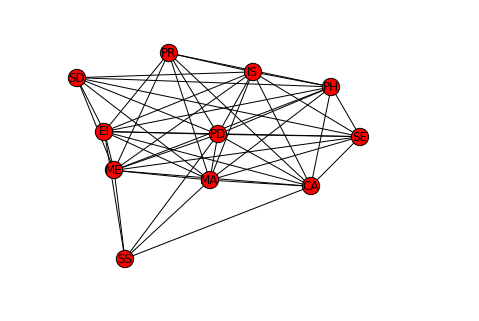

In [10]:
for CN, rexar in enumerate([(christian, christian_tags), (will, will_tags)]):
    plt.clf()
    weighted_graph = nx.MultiGraph()
    for i in range(len(rexar[0])):
        for x, y in itertools.combinations([t for t, val in enumerate(rexar[0][i]) if val > 0], 2):

            weighted_graph.add_edge(rexar[1].columns[x], rexar[1].columns[y])
    nx.draw(nx.Graph(weighted_graph), with_labels=True)
    plt.savefig("Coder " + str(CN+1) +".png")